# Neural Cellular Automatas for growing neural structures

## Imports

In [1]:
import numpy as np
#import requests
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import linen as nn
from flax.core.frozen_dict import freeze, unfreeze
import optax

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm.notebook import tqdm

## Params / Utils

In [2]:
# @title Cellular Automata Parameters
CHANNEL_N = 16  # Number of CA state channels
TARGET_PADDING = 16  # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 256
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5
N_STEPS = 10
TARGET_EMOJI = "🦎"  # @param {type:"string"}

EXPERIMENT_TYPE = "Regenerating"  # @param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing": 0, "Persistent": 1, "Regenerating": 2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


In [3]:
def load_image(url, max_size=TARGET_SIZE):
    r = requests.get(url)
    img = PIL.Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    img = np.float32(img) / 255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = (
        "https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true"
        % code
    )
    return load_image(url)


def to_rgba(x):
    return x[..., :4]


def to_alpha(x):
    return x[..., 3:4].clip(0.0, 1.0)


def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return 1.0 - a + rgb


def get_living_mask(x):
    return x[:, :, :, 3:4] > 0.1
    # return nn.max_pool(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1


def make_seed(size, n=1):
    x = np.zeros([n, size, size, CHANNEL_N], np.float32)
    x[:, size // 2, size // 2, 3:] = 1.0
    return x


## Models

In [4]:
class Perception(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Conv(
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="SAME",
            use_bias=False,
        )(x)


class Update(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Sequential(
            [
                nn.Dense(features=128, use_bias=True),
                nn.relu,
                nn.Dense(features=CHANNEL_N, use_bias=True),
            ]
        )(x)


class CAModel(nn.Module):

    channel_n = CHANNEL_N
    fire_rate = CELL_FIRE_RATE
    angle = 0.0

    def setup(self):
        self.pmodel = Perception()
        self.dmodel = Update()

    @nn.compact
    def __call__(self, x, rng_key, fire_rate=None, step_size=1.0):

        pre_life_mask = get_living_mask(x)

        y = self.pmodel(x)
        dx = self.dmodel(y) * step_size
        if fire_rate is None:
            fire_rate = self.fire_rate

        update_mask = (
            jax.random.uniform(rng_key, shape=x[:, :, :, :1].shape) <= fire_rate
        )
        x += dx * update_mask.astype(jnp.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask
        return x * life_mask.astype(jnp.float32)


def get_kernel(angle=0, channel_n=CHANNEL_N):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = np.cos(angle), jnp.sin(angle)
    kernel = np.stack([identify, c * dx - s * dy, s * dx + c * dy], -1)[:, :, None, :]
    kernel = np.repeat(kernel, channel_n, axis=2)
    kernel = jnp.array(kernel).astype(jnp.float32)
    return kernel


def set_params(self, params, angle=0, channel_n=CHANNEL_N):
    kernel = get_kernel(angle, channel_n)
    params = unfreeze(params)
    params["pmodel"]['Conv_0']["kernel"] = kernel
    params = freeze(params)
    
    return params


## Training

In [5]:
@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

In [7]:
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, size, rng, learning_rate, momentum, angle=0.0):
  """Creates an initial `TrainState`."""
  rng1, rng2 = jax.random.split(rng) 
  params = module.init(rng1, make_seed(size), rng2)['params'] # initialize parameters by passing a template image
  params = set_params(module, params, angle)
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())
  

In [8]:
#@jax.jit
def train_step(state, batch, n_steps):
  grid, target, rng_key = batch
  """Train for a single step."""
  def loss_fn(params):
    out = grid
    for _ in range(n_steps):
      out = state.apply_fn({'params': params}, x=grid, rng_key=rng_key)
    out = state.apply_fn({'params': state.params}, x=grid, rng_key=rng_key)
    loss = ((target - out[..., :4]) ** 2).mean()
    return loss
  grad_fn = jax.grad(loss_fn, allow_int=True)
  grads = grad_fn(state.params)
  print(grads)
  state = state.apply_gradients(grads=grads)
  return state

In [10]:
ca_model = CAModel()
init_rng = jax.random.PRNGKey(0)
learning_rate = 0.01
momentum = 0.9
state = create_train_state(ca_model, TARGET_SIZE, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

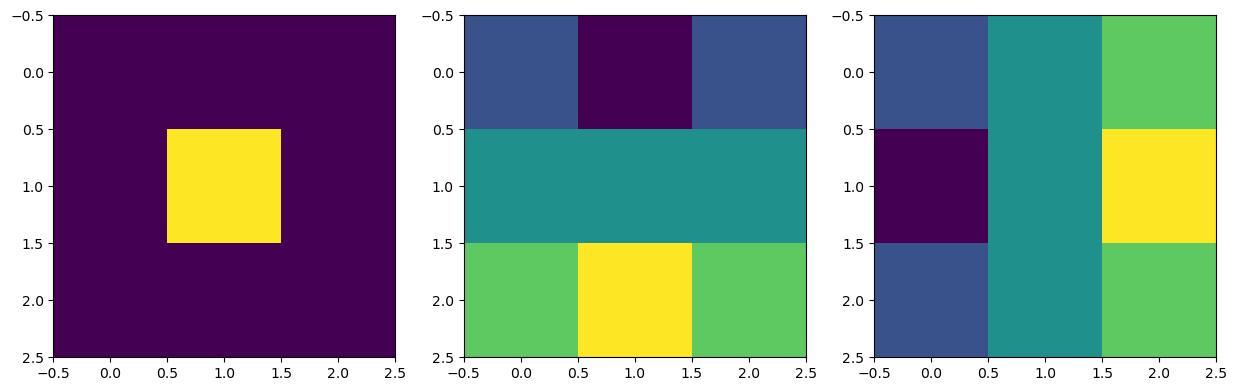

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
[ax.imshow(k) for k, ax in zip(state.params['pmodel']['Conv_0']['kernel'][:, :, 0, :].T, axs)];

In [13]:
rng_key = jax.random.PRNGKey(0)
for batch in tqdm(range(10)):
  rng_key, subkey = jax.random.split(rng_key)
  x = make_seed(TARGET_SIZE, BATCH_SIZE)
  target = np.ones_like(x)[..., :4]
  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, (x, target, subkey), N_STEPS) # get updated train state (which contains the updated parameters)


  0%|          | 0/10 [00:00<?, ?it/s]

FrozenDict({
    dmodel: {
        Dense_0: {
            bias: Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
            kernel: Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


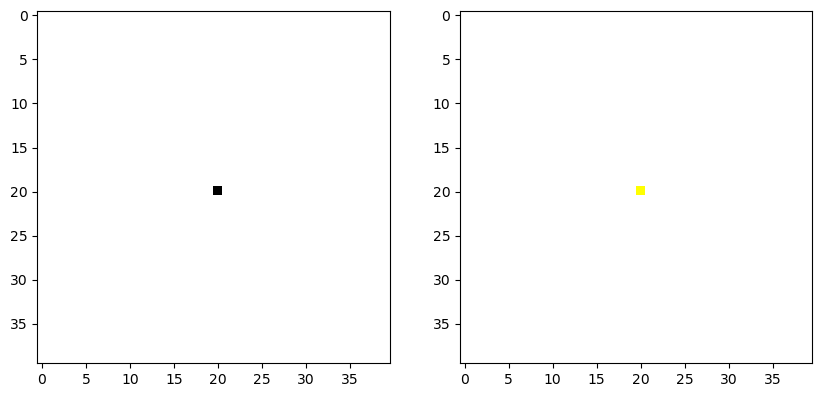

In [209]:
x = make_seed(TARGET_SIZE, BATCH_SIZE)
rng_key, subkey = jax.random.split(rng_key)
out = x.copy()
for _ in range(10) : 
    out = ca_model.apply({'params': state.params}, x=out, rng_key=subkey)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(to_rgb(x[0, ..., :4]))
axs[1].imshow(to_rgb(out[0, ..., :4]))

In [172]:
out[0, ..., :4].mean()

Array(0.00370619, dtype=float32)

In [173]:
target

array([[[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        ...,

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
 